Paquetes necesarios

In [4]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import csv

TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. 

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo. 



In [22]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os 
IMG_PATH = "Monedas.jpg"
CALIB_JSON = "calibracion.json"
COIN_REF = "2 euros"
USE_MPL = False       
SHOW_DEBUG = True
HOUGH_DP = 1.2
HOUGH_PARAM1 = 120
HOUGH_PARAM2 = 50    
HOUGH_MINDIST_F = 0.20  
HOUGH_MINR_F_TIGHT = 0.11
HOUGH_MAXR_F_TIGHT = 0.22
HOUGH_MINR_F_LOOSE = 0.05
HOUGH_MAXR_F_LOOSE = 0.30
HOUGH_MINDIST_F_LOOSE = 0.12
DEDUP_DIST_FRAC = 0.6
DEDUP_RAD_FRAC  = 0.25
TWOTONE_B_THRESH = 6.0    
TWOTONE_LAB_THRESH = 10.0 
CIRC_THRESHOLD = 0.93  

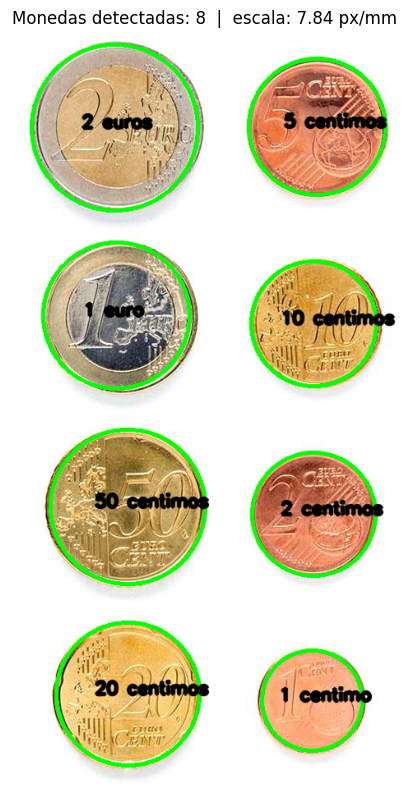

1 centimo: 1
2 centimos: 1
10 centimos: 1
5 centimos: 1
20 centimos: 1
1 euro: 1
50 centimos: 1
2 euros: 1
Total: 3.88 euros


In [27]:
COINS_DIAM_MM = [
    ('1 centimo', 16.25, 0.01),
    ('2 centimos', 18.75, 0.02),
    ('10 centimos', 19.75, 0.10),
    ('5 centimos', 21.25, 0.05),
    ('20 centimos', 22.25, 0.20),
    ('1 euro', 23.25, 1.00),
    ('50 centimos', 24.25, 0.50),
    ('2 euros', 25.75, 2.00),
]
COIN_VALUE = {name: value for name, _, value in COINS_DIAM_MM}
COINS_RAD_MM = {name: diam / 2.0 for name, diam, _ in COINS_DIAM_MM}
COIN_ORDER   = [name for name, _, _ in COINS_DIAM_MM]
count_by_type = {name: 0 for name, _, _ in COINS_DIAM_MM}
def preprocess_image_for_hough(image_bgr):
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    return gray, cv2.equalizeHist(cv2.medianBlur(gray, 7))

def detect_circles(preprocessed, use_tight=True):
    height, width = preprocessed.shape[:2]
    if use_tight:
        min_radius = int(min(height, width) * HOUGH_MINR_F_TIGHT)
        max_radius = int(min(height, width) * HOUGH_MAXR_F_TIGHT)
        min_dist = int(min(height, width) * HOUGH_MINDIST_F)
    else:
        min_radius = int(min(height, width) * HOUGH_MINR_F_LOOSE)
        max_radius = int(min(height, width) * HOUGH_MAXR_F_LOOSE)
        min_dist = int(min(height, width) * HOUGH_MINDIST_F_LOOSE)
    circles = cv2.HoughCircles(preprocessed, cv2.HOUGH_GRADIENT, dp=HOUGH_DP, minDist=min_dist, param1=HOUGH_PARAM1, param2=HOUGH_PARAM2, minRadius=min_radius, maxRadius=max_radius)
    if circles is None:
        return np.empty((0, 3), dtype=int)
    return np.round(circles[0]).astype(int)

def deduplicate_circles(circles, distance_fraction=DEDUP_DIST_FRAC, radius_fraction=DEDUP_RAD_FRAC):
    if circles is None or len(circles) == 0:
        return circles
    items = circles.astype(float).tolist()
    used = [False] * len(items)
    result = []
    for i, (x1, y1, r1) in enumerate(items):
        if used[i]:
            continue
        best = (x1, y1, r1)
        for j, (x2, y2, r2) in enumerate(items):
            if j <= i or used[j]:
                continue
            d = np.hypot(x1 - x2, y1 - y2)
            if d < distance_fraction * min(r1, r2) and abs(r1 - r2) < radius_fraction * min(r1, r2):
                if r2 > best[2]:
                    best = (x2, y2, r2)
                used[j] = True
        used[i] = True
        result.append(best)
    return np.array(np.round(result), dtype=int)

def select_circle_with_click_cv(image_bgr, circles):
    prompt = "Haz clic sobre la moneda de referencia"
    if circles.size == 0:
        raise RuntimeError("No hay círculos para seleccionar.")
    display = image_bgr.copy()
    for i, (x, y, r) in enumerate(circles):
        cv2.circle(display, (x, y), r, (0, 255, 0), 2)
        cv2.putText(display, f"#{i}", (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2, cv2.LINE_AA)
    banner = display.copy()
    h, w = display.shape[:2]
    pad, bar_h = 12, 40
    cv2.rectangle(banner, (0, 0), (w, bar_h + 2 * pad), (0, 0, 0), -1)
    display = cv2.addWeighted(banner, 0.35, display, 0.65, 0.0)
    cv2.putText(display, prompt, (10, 25 + pad // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
    selection = {"pt": None}
    def on_mouse(event, mx, my, *_):
        if event == cv2.EVENT_LBUTTONDOWN:
            selection["pt"] = (mx, my)
    cv2.namedWindow("Calibracion", cv2.WINDOW_NORMAL)
    cv2.imshow("Calibracion", display)
    cv2.setMouseCallback("Calibracion", on_mouse)
    while True:
        key = cv2.waitKey(20) & 0xFF
        if selection["pt"] is not None:
            break
        if key == 27:
            cv2.destroyWindow("Calibracion")
            raise KeyboardInterrupt("Calibración cancelada por el usuario.")
    mx, my = selection["pt"]
    centers = circles[:, :2].astype(float)
    idx = int(np.argmin(np.linalg.norm(centers - np.array([[mx, my]]), axis=1)))
    x, y, r = tuple(circles[idx])
    cv2.circle(display, (x, y), r, (255, 0, 0), 3)
    cv2.circle(display, (mx, my), 5, (255, 0, 0), -1)
    cv2.imshow("Calibracion", display)
    cv2.waitKey(600)
    cv2.destroyWindow("Calibracion")
    return x, y, r

def select_circle_with_click_mpl(image_bgr, circles):
    prompt = "Haz clic sobre la moneda de referencia"
    if circles.size == 0:
        raise RuntimeError("No hay círculos para seleccionar.")
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=(6, 8))
    ax.imshow(image_rgb)
    ax.set_title(prompt)
    ax.axis('off')
    for i, (x, y, r) in enumerate(circles):
        ax.add_patch(plt.Circle((x, y), r, fill=False, linewidth=2))
        ax.text(x, y, f"#{i}", fontsize=10, color='r')
    plt.tight_layout()
    pts = plt.ginput(1, timeout=0)
    plt.close(fig)
    if not pts:
        raise KeyboardInterrupt("Calibración cancelada por el usuario.")
    mx, my = pts[0]
    centers = circles[:, :2].astype(float)
    return tuple(circles[int(np.argmin(np.linalg.norm(centers - np.array([[mx, my]]), axis=1)))])

def calibrate_pixel_scale(image_bgr, reference_coin_name, calib_json=CALIB_JSON, use_mpl=USE_MPL):
    if reference_coin_name not in COINS_RAD_MM:
        raise ValueError(f"Moneda '{reference_coin_name}' no reconocida. Opciones: {list(COINS_RAD_MM.keys())}")
    _, preprocessed = preprocess_image_for_hough(image_bgr)
    circles = deduplicate_circles(detect_circles(preprocessed, use_tight=False))
    if circles.size == 0:
        raise RuntimeError("No se detectaron círculos en calibración. Ajusta parámetros de Hough.")
    picker = select_circle_with_click_mpl if use_mpl else select_circle_with_click_cv
    r_px = float(picker(image_bgr, circles)[2])
    r_mm = COINS_RAD_MM[reference_coin_name]
    scale_px_per_mm = r_px / r_mm
    h, w = image_bgr.shape[:2]
    payload = {"image_size": [h, w], "coin_name": reference_coin_name, "scale_px_per_mm": scale_px_per_mm}
    Path(calib_json).write_text(json.dumps(payload, indent=2), encoding="utf-8")
    return scale_px_per_mm

def load_calibration(calib_json, expected_size=None):
    path = Path(calib_json)
    if not path.exists():
        return None
    try:
        data = json.loads(path.read_text(encoding="utf-8"))
    except Exception:
        return None
    if expected_size and tuple(data.get("image_size", [])) != tuple(expected_size):
        return None
    return data.get("scale_px_per_mm", None)

def extract_coin_color_features_lab(image_bgr, circle, inner_frac=0.55, ring_in=0.65, ring_out=0.95, trim=0.15, glare_V=0.88, glare_S=0.22):
    x, y, r = map(int, circle)
    h, w = image_bgr.shape[:2]
    r = max(5, min(r, min(x, w - 1 - x, y, h - 1 - y)))
    x0, x1 = max(0, x - r), min(w, x + r + 1)
    y0, y1 = max(0, y - r), min(h, y + r + 1)
    roi = image_bgr[y0:y1, x0:x1]
    if roi.size == 0:
        return None
    lab = cv2.cvtColor(roi, cv2.COLOR_BGR2LAB)
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    yy, xx = np.ogrid[:lab.shape[0], :lab.shape[1]]
    cx, cy = x - x0, y - y0
    dist = np.sqrt((xx - cx) ** 2 + (yy - cy) ** 2)
    mask_inner = dist <= (inner_frac * r)
    mask_ring = (dist >= (ring_in * r)) & (dist <= (ring_out * r))
    V = hsv[:, :, 2].astype(np.float32) / 255.0
    S = hsv[:, :, 1].astype(np.float32) / 255.0
    glare_mask = ~((V >= glare_V) & (S <= glare_S))
    def robust_stats(mask):
        mask = mask & glare_mask
        if not np.any(mask):
            return (np.nan, np.nan, np.nan)
        sel = lab[mask].astype(np.float32)
        def trimmed_median(col):
            if col.size == 0:
                return np.nan
            lo = np.quantile(col, trim)
            hi = np.quantile(col, 1.0 - trim)
            col = col[(col >= lo) & (col <= hi)]
            return float(np.median(col)) if col.size > 0 else np.nan
        L = trimmed_median(sel[:, 0])
        a = trimmed_median(sel[:, 1])
        b = trimmed_median(sel[:, 2])
        return (L, a, b)
    Lin, ain, bin_ = robust_stats(mask_inner)
    Lrg, arg, brg = robust_stats(mask_ring)
    delta_b = abs(brg - bin_)
    delta_a = abs(arg - ain)
    delta_lab = float(np.sqrt((Lrg - Lin) ** 2 + (arg - ain) ** 2 + (brg - bin_) ** 2))
    signed_db = float(brg - bin_)
    return {"inner": (Lin, ain, bin_), "ring": (Lrg, arg, brg), "delta_b": delta_b, "delta_a": delta_a, "delta_lab": delta_lab, "signed_db": signed_db}

def compute_coin_circularity(image_gray, circle, canny1=80, canny2=160):
    x, y, r = map(int, circle)
    h, w = image_gray.shape[:2]
    x0, x1 = max(0, x - r - 3), min(w, x + r + 4)
    y0, y1 = max(0, y - r - 3), min(h, y + r + 4)
    roi = image_gray[y0:y1, x0:x1]
    if roi.size == 0:
        return np.nan
    edges = cv2.Canny(roi, canny1, canny2)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return np.nan
    cx, cy = x - x0, y - y0
    best_circularity, best_area = np.nan, 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 50:
            continue
        per = cv2.arcLength(cnt, True)
        if per <= 0:
            continue
        circularity = 4 * np.pi * area / (per * per)
        M = cv2.moments(cnt)
        if M["m00"] == 0:
            continue
        mx, my = int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])
        if np.hypot(mx - cx, my - cy) < 0.25 * r and area > best_area:
            best_area = area
            best_circularity = circularity
    return float(best_circularity)

def compute_adaptive_twotone_threshold(image_bgr, circles, default_b=TWOTONE_B_THRESH):
    values = []
    for circle in circles:
        feats = extract_coin_color_features_lab(image_bgr, circle)
        if feats is None or np.isnan(feats["delta_b"]):
            continue
        values.append(feats["delta_b"])
    if len(values) < 3:
        return default_b
    v = np.array(values, dtype=np.float32)
    v = v[np.isfinite(v)]
    if v.size < 3:
        return default_b
    v = np.clip(v, 0, np.percentile(v, 99.5))
    vmax = v.max() + 1e-6
    v8 = (v / vmax * 255).astype(np.uint8).reshape(-1, 1)
    thr8, _ = cv2.threshold(v8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thr = float(thr8 / 255.0 * vmax)
    return max(thr, default_b * 0.7)

def nearest_index(value, array):
    array = np.asarray(array, dtype=float)
    return int(np.argmin(np.abs(array - value)))

def classify_coin(image_bgr, image_gray, circle, scale_px_per_mm, two_tone_b_thresh=None, two_tone_lab_thresh=TWOTONE_LAB_THRESH, circ_thresh=CIRC_THRESHOLD):
    if two_tone_b_thresh is None:
        two_tone_b_thresh = TWOTONE_B_THRESH
    x, y, r_px = circle
    r_mm = r_px / scale_px_per_mm
    candidate_radii = [COINS_RAD_MM[n] for n in COIN_ORDER]
    idx = nearest_index(r_mm, candidate_radii)
    nearest_name = COIN_ORDER[idx]
    diffs = np.abs(np.array(candidate_radii) - r_mm)
    second = np.argsort(diffs)[1] if len(diffs) > 1 else idx
    second_name = COIN_ORDER[second]
    if {nearest_name, second_name} == {"20 centimos", "1 euro"}:
        color = extract_coin_color_features_lab(image_bgr, circle)
        circularity = compute_coin_circularity(image_gray, circle)
        two_tone = False
        if color is not None and np.isfinite(color["delta_b"]):
            two_tone = (color["delta_b"] > two_tone_b_thresh) or (color["delta_lab"] > two_tone_lab_thresh)
            if two_tone and np.isfinite(color["signed_db"]) and color["signed_db"] < 0:
                two_tone = (color["delta_lab"] > (two_tone_lab_thresh + 2.0))
        if two_tone:
            name = "1 euro"
        else:
            if not np.isnan(circularity) and circularity < circ_thresh:
                name = "20 centimos"
            else:
                name = nearest_name
    else:
        name = nearest_name
    return name, r_mm

def draw_coin_labels(image_bgr, labels):
    out = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    for x, y, r, name, _ in labels:
        cv2.circle(out, (x, y), r, (0, 255, 0), 3)
        cv2.putText(out, name, (x - 40, y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 3, cv2.LINE_AA)
    return out

if __name__ == "__main__":
    image = cv2.imread(IMG_PATH)
    h, w = image.shape[:2]
    scale = load_calibration(CALIB_JSON, expected_size=(h, w))
    if scale is None:
        scale = calibrate_pixel_scale(image, COIN_REF, calib_json=CALIB_JSON, use_mpl=USE_MPL)
    image_gray, preprocessed = preprocess_image_for_hough(image)
    circles = deduplicate_circles(detect_circles(preprocessed))
    two_tone_b_adapt = compute_adaptive_twotone_threshold(image, circles)
    count_by_type = {n: 0 for n, _, _ in COINS_DIAM_MM}
    labels = []
    for x, y, rpx in circles:
        name, r_mm = classify_coin(image, image_gray, (x, y, rpx), scale, two_tone_b_thresh=two_tone_b_adapt)
        count_by_type[name] += 1
        labels.append((x, y, rpx, name, r_mm))
    vis = draw_coin_labels(image, labels)
    plt.figure(figsize=(7, 10))
    plt.axis("off")
    plt.title(f"Monedas detectadas: {len(circles)}  |  escala: {scale:.2f} px/mm")
    plt.imshow(vis)
    plt.show()
    total = 0.0
    total = 0.0
    for k in COIN_ORDER:
        print(f"{k}: {count_by_type[k]}")
        total += count_by_type[k] * COIN_VALUE[k]
    print(f"Total: {total:.2f} euros")
    if Path(CALIB_JSON).exists():
        os.remove(CALIB_JSON)


TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

Umbrales aprendidos: {'thr_tar_v': np.float64(96.113), 'thr_dark_frac': np.float64(0.088), 'thr_circ': np.float64(0.678), 'thr_sol': np.float64(0.94), 'thr_rad': np.float64(0.505)}

Muestras: 97  |  Accuracy: 0.691
FRA: precision=0.667  recall=0.857  f1=0.750  soporte=49
PEL: precision=0.667  recall=0.529  f1=0.590  soporte=34
TAR: precision=1.000  recall=0.500  f1=0.667  soporte=14


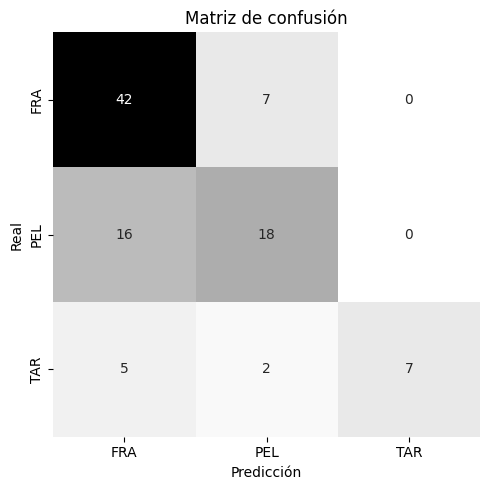

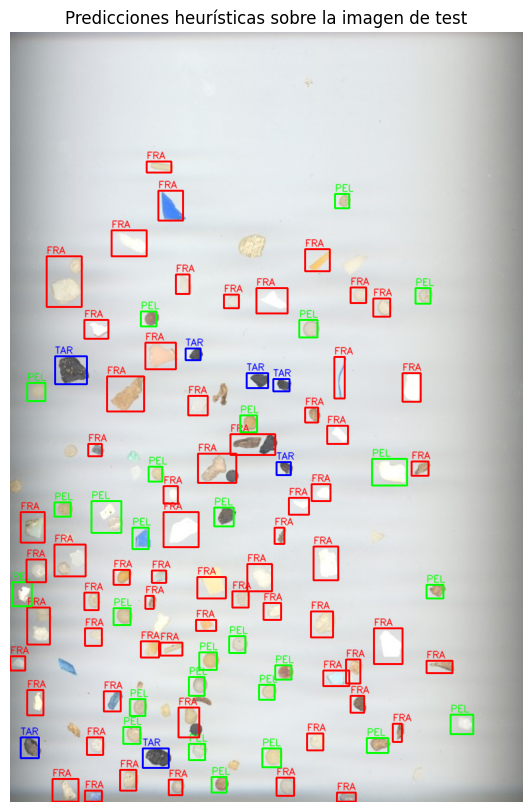

In [42]:
import  math
import numpy as np, pandas as pd
import cv2, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# ----------------- parámetros de ajuste rápido -----------------
# amortiguadores para separar clases (0 = sin margen; 0.1 = 10% del rango intercuartílico)
MARGIN_TAR   = 0.45   # margen extra para detectar TAR (más alto = más TAR)
MARGIN_PEL   = 0.30   # margen extra para pellets (más alto = más pellets)
V_DARK_THR   = 80    # umbral de "pixel oscuro" para dark_frac (en [0..255])
ASPECT_DELTA = 0.35   # tolerancia de aspect ratio alrededor de 1.0 para pellets

# ----------------- utilidades de segmentación -----------------
def clean_mask(mask, open_ksize=3, close_ksize=3, it_open=1, it_close=2):
    k1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_ksize, open_ksize))
    k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_ksize, close_ksize))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  k1, iterations=it_open)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k2, iterations=it_close)
    return mask

def best_binary_mask(gray):
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    _, th_bin = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, th_inv = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    th_bin, th_inv = clean_mask(th_bin), clean_mask(th_inv)
    def largest_area(m):
        cnts,_ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        return 0 if not cnts else cv2.contourArea(max(cnts, key=cv2.contourArea))
    H,W = gray.shape
    a1, a2 = largest_area(th_bin), largest_area(th_inv)
    return th_bin if (a1 >= a2 and a1 < 0.95*H*W) else th_inv

# ----------------- extracción de características -----------------
def contour_features(cnt, roi_bgr, mask):
    gray = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2GRAY)
    area = cv2.contourArea(cnt)
    per  = cv2.arcLength(cnt, True)
    circ = (4*math.pi*area)/(per**2) if per>0 else 0.0
    x,y,w,h = cv2.boundingRect(cnt)
    aspect  = w/h if h>0 else 0.0
    extent  = area/(w*h) if (w*h)>0 else 0.0
    hull    = cv2.convexHull(cnt)
    harea   = cv2.contourArea(hull)
    solidity= (area/harea) if harea>0 else 0.0

    ellipse_ratio = 1.0
    if len(cnt)>=5:
        (_,_),(MA,ma),_ = cv2.fitEllipse(cnt)
        if ma>0:
            r = MA/ma; ellipse_ratio = r if r>=1 else 1.0/r

    M = cv2.moments(cnt)
    cx = (M['m10']/M['m00']) if M['m00']!=0 else (x+w/2)
    cy = (M['m01']/M['m00']) if M['m00']!=0 else (y+h/2)
    pts = cnt.reshape(-1,2)
    d   = np.sqrt((pts[:,0]-cx)**2 + (pts[:,1]-cy)**2)
    rad_ratio = (d.min()/d.max()) if d.max()>0 else 0.0

    hsv    = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2HSV)
    v      = hsv[:,:,2]
    v_mask = v[mask>0]
    v_mean = float(v_mask.mean()) if v_mask.size else 0.0
    p10_v  = float(np.percentile(v_mask, 10)) if v_mask.size else 0.0
    dark_frac = float((v_mask < V_DARK_THR).mean()) if v_mask.size else 0.0
    s_mean = float(hsv[:,:,1][mask>0].mean()) if v_mask.size else 0.0

    return {
        "area": area, "perimeter": per, "circularity": circ,
        "aspect": aspect, "extent": extent, "solidity": solidity,
        "ellipse_ratio": ellipse_ratio, "rad_ratio": rad_ratio,
        "v_mean": v_mean, "p10_v": p10_v, "dark_frac": dark_frac, "s_mean": s_mean
    }

FEATS = ["area","perimeter","circularity","aspect","extent","solidity",
         "ellipse_ratio","rad_ratio","v_mean","p10_v","dark_frac","s_mean"]

def extract_from_class_image(path, label, min_area=30, max_frac=0.3):
    bgr  = cv2.imread(path); assert bgr is not None, f"No se leyó {path}"
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    mask = best_binary_mask(gray)
    cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    H,W = gray.shape; max_area = max_frac*H*W
    rows=[]
    for c in cnts:
        a = cv2.contourArea(c)
        if a<min_area or a>max_area: continue
        m = np.zeros_like(mask); cv2.drawContours(m,[c],-1,255,-1)
        f = contour_features(c, bgr, m); f["label"]=label
        rows.append(f)
    return pd.DataFrame(rows)

# ----------------- aprender umbrales a partir de medianas -----------------
def iqr(v): return np.percentile(v,75)-np.percentile(v,25)

def learn_thresholds(df):
    med = df.groupby("label")[FEATS].median()
    q   = df.groupby("label")[FEATS].quantile

    # TAR por oscuridad (p10_v bajo / dark_frac alto)
    tar_p10   = med.loc["TAR","p10_v"]
    oth_p10   = med.drop(index="TAR")["p10_v"].median()
    thr_tar_v = (tar_p10 + oth_p10)/2.0 + MARGIN_TAR*iqr(df["p10_v"])

    tar_df, oth_df = med.loc["TAR","dark_frac"], med.drop(index="TAR")["dark_frac"].median()
    thr_dark_frac  = (tar_df + oth_df)/2.0 - MARGIN_TAR*iqr(df["dark_frac"])

    # PEL por circularidad/compacidad/redondez
    thr_circ = (med.loc["PEL","circularity"] + med.loc["FRA","circularity"])/2.0 - MARGIN_PEL*iqr(df["circularity"])
    thr_sol  = (med.loc["PEL","solidity"]    + med.loc["FRA","solidity"])   /2.0 - MARGIN_PEL*iqr(df["solidity"])
    thr_rad  = (med.loc["PEL","rad_ratio"]   + med.loc["FRA","rad_ratio"])  /2.0 - MARGIN_PEL*iqr(df["rad_ratio"])

    return dict(thr_tar_v=thr_tar_v, thr_dark_frac=thr_dark_frac,
                thr_circ=thr_circ, thr_sol=thr_sol, thr_rad=thr_rad, med=med)

def is_pellet_like(f, thr):
    near_square = (1.0-ASPECT_DELTA) <= f["aspect"] <= (1.0+ASPECT_DELTA)
    roundish    = (f["ellipse_ratio"] <= 1.5)
    return (f["circularity"] >= thr["thr_circ"] and
            f["solidity"]    >= thr["thr_sol"]  and
            f["rad_ratio"]   >= thr["thr_rad"]  and
            near_square and roundish)

def predict_heuristic(f, thr):
    # 1) TAR por oscuridad robusta
    if (f["p10_v"] < thr["thr_tar_v"]) or (f["dark_frac"] > thr["thr_dark_frac"]):
        return "TAR"
    # 2) PEL por redondez/compacidad
    if is_pellet_like(f, thr):
        return "PEL"
    # 3) resto FRA
    return "FRA"

# ----------------- evaluación -----------------
def load_annotations(path_csv):
    try:
        df = pd.read_csv(path_csv, sep="\t")
        if {'label','x_min','y_min','x_max','y_max'}.difference(df.columns):
            raise Exception("sep")
    except Exception:
        df = pd.read_csv(path_csv)
    return df

def evaluate_on_test(path_img, path_csv, thresholds):
    img = cv2.imread(path_img); assert img is not None, f"No se leyó {path_img}"
    H,W,_ = img.shape
    df = load_annotations(path_csv)

    y_true, y_pred = [], []
    vis = img.copy()

    for _,r in df.iterrows():
        gt = str(r["label"])
        x0,y0,x1,y1 = map(int, [r["x_min"], r["y_min"], r["x_max"], r["y_max"]])
        x0=max(0,x0); y0=max(0,y0); x1=min(W-1,x1); y1=min(H-1,y1)
        roi = img[y0:y1, x0:x1]
        if roi.size==0: continue

        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        mask = best_binary_mask(gray)
        cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not cnts: continue
        cnt = max(cnts, key=cv2.contourArea)
        m = np.zeros_like(mask); cv2.drawContours(m,[cnt],-1,255,-1)
        f = contour_features(cnt, roi, m)

        pred = predict_heuristic(f, thresholds)
        y_true.append(gt); y_pred.append(pred)

        color = dict(FRA=(0,0,255), PEL=(0,255,0), TAR=(255,0,0)).get(pred,(0,0,0))
        cv2.rectangle(vis,(x0,y0),(x1,y1),color,2)
        cv2.putText(vis, pred, (x0,y0-4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

    return np.array(y_true), np.array(y_pred), vis

def show_confusion(y, yhat, labels=("FRA","PEL","TAR")):
    cm = confusion_matrix(y, yhat, labels=list(labels))
    acc = accuracy_score(y, yhat)
    pr, rc, f1, sup = precision_recall_fscore_support(y, yhat, labels=list(labels), zero_division=0)

    print(f"\nMuestras: {len(y)}  |  Accuracy: {acc:.3f}")
    for i,l in enumerate(labels):
        print(f"{l}: precision={pr[i]:.3f}  recall={rc[i]:.3f}  f1={f1[i]:.3f}  soporte={sup[i]}")

    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Greys',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicción"); plt.ylabel("Real"); plt.title("Matriz de confusión")
    plt.tight_layout(); plt.show()
    return cm

# ----------------- MAIN (ejecutar con Run) -----------------
PATH_FRA = "FRA.png"
PATH_PEL = "PEL.png"
PATH_TAR = "TAR.png"
PATH_TEST_IMG = "MPs_test.jpg"     # o MPs_test.png si la tuya es PNG
PATH_TEST_CSV = "MPs_test_bbs.csv"

df_train = pd.concat([
    extract_from_class_image(PATH_FRA, "FRA", min_area=30),
    extract_from_class_image(PATH_PEL, "PEL", min_area=30),
    extract_from_class_image(PATH_TAR, "TAR", min_area=30),
], ignore_index=True)

assert not df_train.empty, "No se extrajeron partículas; revisa rutas/archivos."
thr = learn_thresholds(df_train)
print("Umbrales aprendidos:", {k:round(v,3) for k,v in thr.items() if k!='med'})

y, yhat, vis = evaluate_on_test(PATH_TEST_IMG, PATH_TEST_CSV, thr)
_ = show_confusion(y, yhat, labels=("FRA","PEL","TAR"))

plt.figure(figsize=(8,10))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.title("Predicciones heurísticas sobre la imagen de test")
plt.show()
